In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
from skimage import io
import numpy as np
from albumentations.pytorch.transforms import ToTensor
import albumentations as A
import pandas as pd
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


In [ ]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
def plot_images(images_for_show, titles):
  """Строит изображение на одном графике"""
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(titles[i - 1])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_for_show[i - 1])
    
  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self, df):
        self.transforms = A.Compose([
              A.Resize(256, 256),
              A.Normalize(),
              ToTensor()
        ])
        self.df = df

    def __len__(self):
        return len(self.df)

    
    def _load_file(self, path):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def __getitem__(self, idx):
        now = self.df.iloc[idx]
        x = self._load_file(now['path'])
        y = now['label']
        transformed = self.transforms(image=x)['image']
        
        return transformed, y

In [ ]:
data_dir = '/content/drive/MyDrive/face_cartonizing'

bad_path = os.path.join(data_dir, 'bad')
good_path = os.path.join(data_dir, 'good')

paths = [os.path.join(bad_path, name) for name in os.listdir(bad_path)] + \
            [os.path.join(good_path, name) for name in os.listdir(good_path)]
labels = [0] * len(os.listdir(bad_path)) + [1] * len(os.listdir(good_path))

df = pd.DataFrame({'path': paths, 'label': labels})
df.head()

,path,label
0,/content/drive/MyDrive/face_cartonizing/bad/se...,0
1,/content/drive/MyDrive/face_cartonizing/bad/se...,0
2,/content/drive/MyDrive/face_cartonizing/bad/se...,0
3,/content/drive/MyDrive/face_cartonizing/bad/se...,0
4,/content/drive/MyDrive/face_cartonizing/bad/se...,0


In [ ]:
len(df[df['label'] == 0]), len(df[df['label'] == 1])

(316, 294)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
train_dataset = ClassifierDataset(train_df)
test_dataset = ClassifierDataset(test_df)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model = model.to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [ ]:
model(batch[0].to(device)).shape

torch.Size([8, 1])

In [ ]:
def train_epoch(model, batch_gen, criterion, optimizer, is_train = True) :
  epoch_loss = 0.0
  count = 0
  accuracy = 0
  model.train(is_train)
  
  for input, labels in tqdm(batch_gen) :
    input = input.to(device)
    labels = labels.to(device).reshape(-1, 1).to(torch.float)
    
    with torch.set_grad_enabled(is_train) :
      pred = model(input)
      loss = criterion(pred, labels)
      accuracy += torch.sum((pred > 0.5) == labels)
      
      if is_train :
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      count += input.shape[0]
      epoch_loss += loss.item()

  return epoch_loss / count, accuracy / count

In [ ]:
import copy

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs) :
  best_acc = 0
  best_model = None

  loader = {'train' : train_loader, 'test' : test_loader}
  loss_history = {'train' : [], 'test' : []}
  acc_history = {'train' : [], 'test' : []}

  for epoch in range(num_epochs) :
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'test'] :
      epoch_loss, epoch_acc = train_epoch(model, loader[phase], criterion, optimizer, phase == 'train')
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      loss_history[phase].append(epoch_loss)
      acc_history[phase].append(epoch_acc)
    
    if best_acc < acc_history['test'][-1]:
      best_acc = acc_history['test'][-1]
      best_model = copy.deepcopy(model)

    print()
  
  return loss_history, acc_history, best_model

In [ ]:
loss_train, acc_train, model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

Epoch 0/14
----------


100%|██████████| 61/61 [00:17<00:00,  3.56it/s]


train Loss: 0.0754 Acc: 0.6885


100%|██████████| 16/16 [00:04<00:00,  3.45it/s]


test Loss: 0.0589 Acc: 0.8197

Epoch 1/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.78it/s]


train Loss: 0.0493 Acc: 0.8484


100%|██████████| 16/16 [00:03<00:00,  4.86it/s]


test Loss: 0.0531 Acc: 0.8443

Epoch 2/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.89it/s]


train Loss: 0.0444 Acc: 0.8443


100%|██████████| 16/16 [00:02<00:00,  5.77it/s]


test Loss: 0.1014 Acc: 0.7131

Epoch 3/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0372 Acc: 0.8770


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


test Loss: 0.0639 Acc: 0.8197

Epoch 4/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.90it/s]


train Loss: 0.0332 Acc: 0.9016


100%|██████████| 16/16 [00:02<00:00,  5.84it/s]


test Loss: 0.0730 Acc: 0.7131

Epoch 5/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0307 Acc: 0.9139


100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


test Loss: 0.0466 Acc: 0.8361

Epoch 6/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.85it/s]


train Loss: 0.0203 Acc: 0.9385


100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


test Loss: 0.0545 Acc: 0.8361

Epoch 7/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.92it/s]


train Loss: 0.0297 Acc: 0.9283


100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


test Loss: 0.0823 Acc: 0.7787

Epoch 8/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.91it/s]


train Loss: 0.0255 Acc: 0.9283


100%|██████████| 16/16 [00:02<00:00,  6.06it/s]


test Loss: 0.0532 Acc: 0.8197

Epoch 9/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0115 Acc: 0.9672


100%|██████████| 16/16 [00:02<00:00,  5.89it/s]


test Loss: 0.0601 Acc: 0.8525

Epoch 10/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.87it/s]


train Loss: 0.0120 Acc: 0.9590


100%|██████████| 16/16 [00:02<00:00,  5.86it/s]


test Loss: 0.0589 Acc: 0.8279

Epoch 11/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0130 Acc: 0.9611


100%|██████████| 16/16 [00:02<00:00,  6.04it/s]


test Loss: 0.0820 Acc: 0.7869

Epoch 12/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0133 Acc: 0.9672


100%|██████████| 16/16 [00:02<00:00,  5.94it/s]


test Loss: 0.0551 Acc: 0.8770

Epoch 13/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.91it/s]


train Loss: 0.0193 Acc: 0.9488


100%|██████████| 16/16 [00:02<00:00,  5.85it/s]


test Loss: 0.0699 Acc: 0.8443

Epoch 14/14
----------


100%|██████████| 61/61 [00:12<00:00,  4.88it/s]


train Loss: 0.0096 Acc: 0.9693


100%|██████████| 16/16 [00:02<00:00,  5.95it/s]

test Loss: 0.0779 Acc: 0.8770



In [ ]:
train_epoch(model, test_loader, criterion, optimizer, False)

100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


(0.0551010981186858, tensor(0.8770, device='cuda:0'))

In [ ]:
cartoon_path = os.path.join(data_dir, 'cartoon')
paths = [os.path.join(cartoon_path, name) for name in os.listdir(cartoon_path)]
labels = [int(name[name.find('_') + 1:-4]) for name in os.listdir(cartoon_path)]
cartoon_df = pd.DataFrame({'path': paths, 'label': labels})

full_dataset = ClassifierDataset(cartoon_df)
full_loader = DataLoader(full_dataset, batch_size=batch_size, num_workers=8, shuffle=True)

In [ ]:
full_dataset[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
mean=torch.Tensor([0.485, 0.456, 0.406])
std=torch.Tensor([0.229, 0.224, 0.225])
undo_norm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

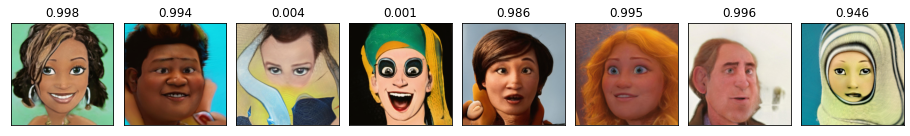

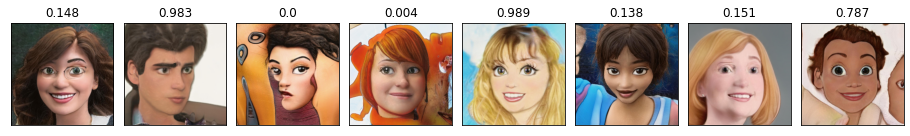

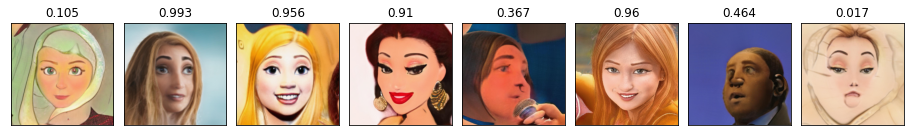

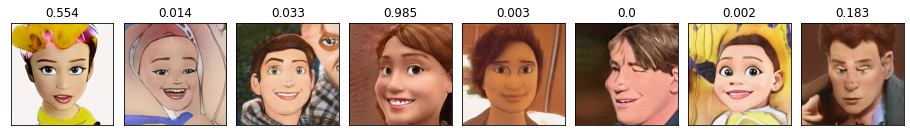

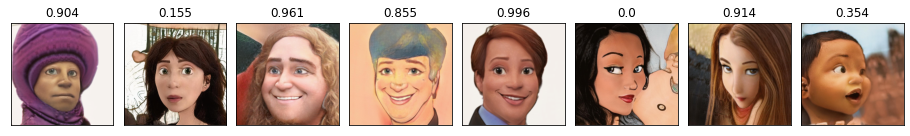

In [ ]:
n = 5
for input, labels in full_loader:
    input = input.to(device)
    labels = labels.to(device).reshape(-1, 1).to(torch.float)
    pred = model(input).view(-1)
    pred = [round(el.item(), 3) for el in pred]
    plot_images(torch.moveaxis(undo_norm(input), 1, -1).cpu().detach().numpy(), pred)
    n -= 1
    if not n:
      break

In [ ]:
res = {}
for input, labels in tqdm(full_loader):
    input = input.to(device)
    pred = model(input).view(-1)
   
    for p, seed in zip(pred, labels):
        res['seed_{}.jpg'.format(seed.item())] = p.item()

100%|██████████| 2401/2401 [09:15<00:00,  4.32it/s]


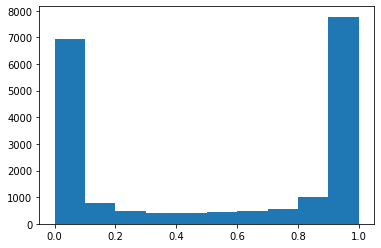

In [ ]:
plt.hist(res.values())
plt.show()

In [ ]:
sum(np.array(list(res.values())) > 0.8)

8761

In [ ]:
import pickle

with open('/content/drive/MyDrive/face_cartonizing/quality.pickle', 'wb') as f:
  pickle.dump(res, f)